# Logistic Regression

## Declaring Functions

### Importing Libraries

In [1]:
import random
import numpy as np
import scipy.sparse as sparse

import tqdm as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

seed = 69420
np.random.seed(69420)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import SMOTE

### Auxiliary Functions

In [2]:
def calculate_loss(*, y, s):
    e = 1e-8
    return -np.sum(y * np.log(s + e)).mean()

def multilogistic(*, z):
    z = z - np.max(z, axis=0, keepdims=True)
    return np.exp(z) / np.sum(np.exp(z), axis=0, keepdims=True)

def calculate_gradient(*, X, y, s):
    return (y.T - s) @ X

def predict(*, X, W):
    return multilogistic(z=W @ X.T)

def accuracy(*, y_true, y_pred):
    return np.sum(y_true == y_pred) / y_true.shape[0]

### Logistic Regression Function

In [3]:
def logistic_regression(X, y, Xv, yv, 
                        W_init=None, epochs=1000, minEpoch=5, 
                        eta=1e-2, lambda_=1e-2, threshold=1e-6):
    
    # Initialize weights matrix
    if W_init is None:
        W = np.random.normal(0, 0.1, (y.shape[1], X.shape[1])) 
        W = np.hstack((np.zeros((y.shape[1],1)), W))
    else:
        W = W_init

    # Add an extra row for bias
    X = sparse.hstack((np.ones((X.shape[0], 1)), X))
    Xv = sparse.hstack((np.ones((Xv.shape[0], 1)), Xv))
    
    # Initialize metrics arrays
    losses = []
    lossesV = []
    accuracies = []
    accuraciesV = []

    
    try:
        with tqdm.trange(epochs) as t:
            for i in t:

                # Obtaining the results fron the multi logistic regression function
                s = multilogistic(z=W @ X.T)  
                st = multilogistic(z=W @ Xv.T)
                
                # Applying gradient descent
                gradient = calculate_gradient(X = X, y = y, s = s) - (lambda_ * W)

                # Calculating loss and storing metrics
                loss = calculate_loss(y = y, s = s.T) + (lambda_/2) * np.sum(W**2)
                losses.append(loss)
                lossV = calculate_loss(y = yv, s = st.T) + (lambda_/2) * np.sum(W**2)
                lossesV.append(lossV)

                # Calculating accuracy and storing metrics
                accuracy_ = accuracy(y_true = np.argmax(y, axis=1), y_pred = np.argmax(predict(X=X,W=W), axis=0))
                t.set_postfix(loss=f"{loss:.6f}", accuracy=f"{accuracy_:.6f}")
                accuracies.append(accuracy_)
                accuracyV_ = accuracy(y_true = np.argmax(yv, axis=1), y_pred = np.argmax(predict(X=Xv,W=W), axis=0))
                t.set_postfix(lossV=f"{lossV:.6f}", accuracyV=f"{accuracyV_:.6f}")
                accuraciesV.append(accuracyV_)

                # Converging criteria
                if i > minEpoch:
                    if np.abs(losses[-1] - losses[-2]) < threshold:
                        print("Converged at epoch ", i)
                        break

                # Updating weight
                W = W + eta * gradient

    except KeyboardInterrupt:
        print("Interrupted by user at epoch ", i)

    return W, losses, lossesV, accuracies, accuraciesV


## Preprocessing

### Loading the data

Uploading the classes

In [4]:
Y = open('/kaggle/input/cs429529-project-2-topic-categorization/newsgrouplabels.txt', 'r')
classes = []
for line in Y:
    y = line.split()
    classes.append(y)

Uploading the vocabulary

In [5]:
vocabs = open('/kaggle/input/cs429529-project-2-topic-categorization/vocabulary.txt', 'r')
vocabulary = []
for line in vocabs:
    vocab = line.split()
    vocabulary.append(vocab[0])

Uploading the datasets

In [6]:
# Function to load data into a sparse matrix
def read_sparse_dataset(dataset_name: str, *args, **kwargs) -> sparse.csr_matrix:
    # Opening the file and counting the number of lines it has
    with open(dataset_name, 'r') as f:
        num_lines = sum(1 for _ in f)

    # Initializing an empty list of sparse matrix rows
    sparse_row_list = []
    with open(dataset_name, 'r') as f:
        # Inputting the data of each line into the list
        for row in tqdm.tqdm(f, total=num_lines):
            data = np.fromstring(row, *args, **kwargs)
            sparse_row = sparse.csr_matrix(data)
            sparse_row_list.append(sparse_row)

    # Converting the list into a matrix
    data_matrix: sparse.csr_matrix
    data_matrix = sparse.vstack(sparse_row_list)
    
    # Returning the final result
    return data_matrix

In [7]:
# Loading the training data into a sparse matrix
Xy_raw: sparse.csr_matrix
Xy_raw = read_sparse_dataset("/kaggle/input/cs429529-project-2-topic-categorization/training.csv", sep=',', dtype=np.int32)

100%|██████████| 12000/12000 [00:26<00:00, 449.27it/s]


In [8]:
# Loading the testing data into a sparse matrix
xTest: sparse.csr_matrix
xTest = read_sparse_dataset("/kaggle/input/cs429529-project-2-topic-categorization/testing.csv", sep=',', dtype=np.int32)

100%|██████████| 6774/6774 [00:15<00:00, 430.26it/s]


Transforming to arrays

In [9]:
# Separating the training data into features and classes
X_bow = Xy_raw[:, 1:-1].toarray()
y_bow = Xy_raw[:, -1].toarray()
# Making an array for the test data
xTest_bow = xTest[:, 1:].toarray()

## Word Ranking

Initial normalization and encoding

In [10]:
# Initializing the scaler
scaler = StandardScaler(with_mean=False)
# Fitting the data to the scaler
scaler.fit(X_bow)
# Making a new matrix for the normalized values
X_norm = sparse.csr_matrix(scaler.transform(X_bow))
xTest_norm = sparse.csr_matrix(scaler.transform(xTest_bow))

# Encode the classes using One Hot Encoder
encoder = OneHotEncoder()
y_cat = encoder.fit_transform(y_bow.reshape(-1, 1))

Splitting the dataset

In [11]:
# Making the train/test split and converting them to arrays
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_cat, test_size=0.2, stratify=np.asarray(np.argmax(y_cat, axis=1)), random_state=seed)
y_train, y_val = y_train.toarray(), y_val.toarray()

Obtaining the weights matrix

In [12]:
# Initial run for the lineal regression to obtain the weights matrix
W, losses, lossesV, accuracies, accuraciesV = logistic_regression(X_train, y_train, X_val, y_val, epochs = 1000, minEpoch = 5, eta = 1e-1, lambda_ = 1e-3, threshold = 1)

  4%|▍         | 38/1000 [00:19<08:14,  1.95it/s, accuracyV=0.831250, lossV=16648.332683]

Converged at epoch  38


Using Mutual Learning

In [13]:
# Function for obtaining the word ranking using Mutual Information
def rankWords(vocabulary, X_train, W):
    # Softmax function to find the probability of a word according to its class
    def softmax(z):
        z_exp = np.exp(z - np.max(z, axis=1, keepdims=True))
        return z_exp / np.sum(z_exp, axis=1, keepdims=True)
    
    #Calculating the probability
    vocArr = np.array(vocabulary)
    Xt_bias = sparse.hstack((np.ones((X_train.shape[0], 1)), X_train))
    y_train_pred = softmax(Xt_bias @ W.T)
    P_Y = y_train_pred.mean(axis=0)
    
    P_X_given_Y = softmax(W[:, 1:])
    
    P_X = np.zeros(P_X_given_Y.shape[1])
    for i in range(P_Y.shape[0]):
        P_X += P_X_given_Y[i] * P_Y[i]
    
    P_X_Y = np.zeros((P_Y.shape[0], P_X.shape[0]))
    for i in range(P_Y.shape[0]):
        P_X_Y[i, :] = P_X_given_Y[i] * P_Y[i]
        
    MI = np.zeros((P_Y.shape[0], P_X.shape[0]))
    for i in range(P_Y.shape[0]):
        MI[i, :] = P_X_Y[i, :] * np.log2((P_X_Y[i, :] + 1e-8) / ((P_X + 1e-8) * (P_Y[i] + 1e-8)))
    
    word_MI = MI.sum(axis=0)
    
    word_ranking = np.argsort(word_MI)[::-1]
    
    return vocArr[word_ranking], word_MI[word_ranking]

In [14]:
# Obtaining the word ranking
vocArr, wordMI = rankWords(vocabulary, X_train, W)

In [15]:
# Printing the top 100 words
print(vocArr[:100])

['athos' 'bike' 'playoffs' 'ide' 'clipper' 'baseball' 'circuit' 'geb'
 'sale' 'cica' 'apple' 'animation' 'henry' 'cars' 'cdt' 'arab' 'cramer'
 'kendig' 'benedikt' 'window' 'sunos' 'motif' 'beauchaine' 'guns' 'car'
 'sandvik' 'shuttle' 'israel' 'optilink' 'bobbe' 'zoo' 'israeli' 'buphy'
 'polygon' 'sahak' 'melkonian' 'windows' 'graphics' 'psyrobtw'
 'ceccarelli' 'quadra' 'tga' 'appressian' 'partial' 'ohanus' 'images'
 'turks' 'gregg' 'newton' 'jaeger' 'turkish' 'royalroads' 'mlee' 'malcolm'
 'clayton' 'armenians' 'christian' 'image' 'bible' 'ico' 'texture' 'offer'
 'convert' 'ini' 'occupied' 'ksand' 'extermination' 'rutgers' 'vos'
 'bskendig' 'apps' 'armenia' 'circuits' 'iff' 'jxp' 'geometric' 'centris'
 'kent' 'weiss' 'tdawson' 'herringshaw' 'abortion' 'disease' 'shipping'
 'arabs' 'dx' 'spencer' 'rendering' 'byuvm' 'bus' 'chastity' 'formats'
 'medicine' 'med' 'burden' 'keith' 'alink' 'sky' 'olwm' 'skepticism']


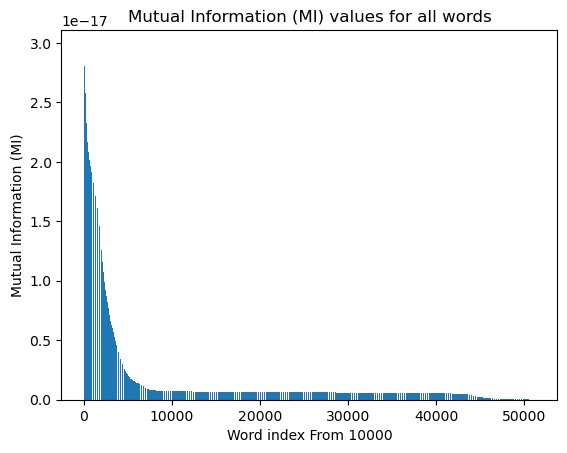

In [16]:
# Plotting the results
top_word_MI = wordMI[10000:]

plt.bar(range(len(top_word_MI)), top_word_MI)
plt.xlabel('Word index From 10000')
plt.ylabel('Mutual Information (MI)')
plt.title('Mutual Information (MI) values for all words')
plt.show()

### Feature Exraction

Applying tf-idf

In [17]:
# Calling the transformer and fitting it to the data
transformer = TfidfTransformer()
transformer.fit(X_bow)

# Updating the matrixes
X_tfidf = transformer.transform(X_bow)
xTest_tfidf = transformer.transform(xTest_bow)

Using Chi-Squared considering the value of `k` obtained in the word ranking step.

In [18]:
# Calling the selector with the specified parameters
selector = SelectKBest(chi2, k=25000)

# Fitting the data using chi-squared
X_chi = selector.fit_transform(X_tfidf, y_bow)
xTest_chi = selector.transform(xTest_tfidf)

### Data Augementation

Adding SMOTE Encoding

In [19]:
# Adjusting SMOTE over the data
smote = SMOTE(random_state=42)
X_smote, Y_smote = smote.fit_resample(X_chi, y_bow.ravel())

Standarizing the features

In [20]:
# Standarizing the features using SMOTE
scaler = StandardScaler(with_mean=False)
scaler.fit(X_smote)
X_norm = sparse.csr_matrix(scaler.transform(X_smote))
xTest_norm = sparse.csr_matrix(scaler.transform(xTest_chi))

Encoding the classes

In [21]:
# Applying One Hot Encoding over the classes
encoder = OneHotEncoder()
y_cat = encoder.fit_transform(Y_smote.reshape(-1, 1))

## Training

### Finding the optimal values of eta and lambda

In [22]:
import random

# Random search initialization
noOfIters = 30
rsLt, rsLv, rsAt, rsAv, etas, lmbdas = [], [], [], [], [], []

# Search loop
for i in range(noOfIters):
    print("Iteration:", i)
    
    # Picking random values for eta and lambda
    eta = random.uniform(0.001, 0.01)
    lmbda = random.uniform(0.001, 0.01)
    
    # Calculating logistic regression using said values
    W, losses, lossesV, accuracies, accuraciesV = logistic_regression(X_train, y_train, X_val, y_val, 
                                                                      epochs = 1000, minEpoch = 5, 
                                                                      eta = eta, lambda_ = lmbda, threshold = 1)
    
    # Store results from evaluation
    rsLt.append(np.mean(losses))
    rsLv.append(np.mean(lossesV))
    rsAt.append(np.mean(accuracies))
    rsAv.append(np.mean(accuraciesV))
    etas.append(eta)
    lmbdas.append(lmbda)
    
    # Outputting the results
    print(f"eta: {etas[i]}, lambda: {lmbdas[i]}, Train Loss: {rsLt[i]}, Validation Loss: {rsLv[i]}, Train Accuracy: {rsAt[i]}, Validation Accuracy: {rsAv[i]} ")

# Outputting the optimal results
print(f"Best eta: {etas[np.argmax(rsAv)]}, Best lambda: {lmbdas[np.argmax(rsAv)]}")    

Iteration: 0


100%|██████████| 1000/1000 [08:11<00:00,  2.03it/s, accuracyV=0.825833, lossV=6479.393800]


eta: 0.004272393278588284, lambda: 0.005864888035546493, Train Loss: 374.5143104476746, Validation Loss: 6465.076183660101, Train Accuracy: 0.9982997916666668, Validation Accuracy: 0.8273683333333334 
Iteration: 1


  2%|▏         | 20/1000 [00:10<08:39,  1.89it/s, accuracyV=0.829583, lossV=7195.652785]


Converged at epoch  20
eta: 0.00890374037516702, lambda: 0.005346886981365431, Train Loss: 8107.586557656948, Validation Loss: 8733.008408976002, Train Accuracy: 0.9488392857142859, Validation Accuracy: 0.7901984126984127 
Iteration: 2


  1%|          | 12/1000 [00:06<08:55,  1.85it/s, accuracyV=0.833333, lossV=6997.437128]


Converged at epoch  12
eta: 0.00891781089914698, lambda: 0.00445905911828832, Train Loss: 12462.676212068616, Validation Loss: 9429.564395952331, Train Accuracy: 0.920128205128205, Validation Accuracy: 0.7702564102564102 
Iteration: 3


 47%|████▋     | 471/1000 [03:58<04:28,  1.97it/s, accuracyV=0.830417, lossV=7066.243002]


Converged at epoch  471
eta: 0.00991907903705858, lambda: 0.001855011765611348, Train Loss: 614.6274847018778, Validation Loss: 7121.2389390690005, Train Accuracy: 0.9971016507768363, Validation Accuracy: 0.8285134180790962 
Iteration: 4


100%|██████████| 1000/1000 [08:07<00:00,  2.05it/s, accuracyV=0.825000, lossV=6964.953876]


eta: 0.007288204687307669, lambda: 0.0025211713349792995, Train Loss: 375.74321449026417, Validation Loss: 6992.260260111617, Train Accuracy: 0.998360729166667, Validation Accuracy: 0.8244208333333332 
Iteration: 5


100%|██████████| 1000/1000 [08:12<00:00,  2.03it/s, accuracyV=0.820000, lossV=7426.607085]


eta: 0.008863334855176094, lambda: 0.0030565347491891006, Train Loss: 474.1586564124627, Validation Loss: 7454.782354673485, Train Accuracy: 0.9983531250000003, Validation Accuracy: 0.82006375 
Iteration: 6


  4%|▍         | 40/1000 [00:19<07:53,  2.03it/s, accuracyV=0.817083, lossV=6728.535310]


Converged at epoch  40
eta: 0.004164413870612983, lambda: 0.0023093897039278295, Train Loss: 3971.5388665813393, Validation Loss: 7498.613740546166, Train Accuracy: 0.9734400406504066, Validation Accuracy: 0.7972764227642278 
Iteration: 7


  1%|          | 8/1000 [00:04<08:41,  1.90it/s, accuracyV=0.681250, lossV=9924.917692] 


Converged at epoch  8
eta: 0.0011704281808280913, lambda: 0.005816940511174275, Train Loss: 17842.097567098124, Validation Loss: 13204.809116028207, Train Accuracy: 0.875, Validation Accuracy: 0.6024537037037037 
Iteration: 8


100%|██████████| 1000/1000 [08:08<00:00,  2.05it/s, accuracyV=0.824167, lossV=7274.344845]


eta: 0.00968083210855612, lambda: 0.002566752343822137, Train Loss: 494.2789589346842, Validation Loss: 7207.383358018411, Train Accuracy: 0.9983058333333336, Validation Accuracy: 0.8255504166666666 
Iteration: 9


  1%|▏         | 14/1000 [00:07<08:46,  1.87it/s, accuracyV=0.823333, lossV=6991.616362]


Converged at epoch  14
eta: 0.006715470569269288, lambda: 0.0026841062738034637, Train Loss: 10940.299075875191, Validation Loss: 9196.514447612428, Train Accuracy: 0.9284444444444445, Validation Accuracy: 0.7676111111111112 
Iteration: 10


  1%|▏         | 14/1000 [00:07<08:44,  1.88it/s, accuracyV=0.830833, lossV=6836.504106]


Converged at epoch  14
eta: 0.008473141170391085, lambda: 0.0015674205387435302, Train Loss: 10644.2392181093, Validation Loss: 8950.135222867442, Train Accuracy: 0.9301736111111112, Validation Accuracy: 0.7769722222222222 
Iteration: 11


  2%|▏         | 15/1000 [00:07<08:19,  1.97it/s, accuracyV=0.780000, lossV=7440.646150]


Converged at epoch  15
eta: 0.002311054576966035, lambda: 0.0025205436745490886, Train Loss: 9824.636104101479, Validation Loss: 9420.601742301105, Train Accuracy: 0.9326888020833333, Validation Accuracy: 0.7305729166666667 
Iteration: 12


  2%|▏         | 24/1000 [00:12<08:15,  1.97it/s, accuracyV=0.839167, lossV=6962.576657]


Converged at epoch  24
eta: 0.00884433091096766, lambda: 0.006230952211396823, Train Loss: 6963.402282073775, Validation Loss: 8281.796146326476, Train Accuracy: 0.9569791666666666, Validation Accuracy: 0.8038500000000001 
Iteration: 13


  2%|▏         | 15/1000 [00:07<08:38,  1.90it/s, accuracyV=0.816250, lossV=7412.827592]


Converged at epoch  15
eta: 0.006181463755027682, lambda: 0.008570381443377097, Train Loss: 10382.634033667764, Validation Loss: 9403.622262606259, Train Accuracy: 0.9333723958333334, Validation Accuracy: 0.7652864583333333 
Iteration: 14


  3%|▎         | 26/1000 [00:12<08:01,  2.02it/s, accuracyV=0.778750, lossV=7119.545628]


Converged at epoch  26
eta: 0.0022203835198415936, lambda: 0.0024246647381481958, Train Loss: 5846.308947451682, Validation Loss: 8283.723940082316, Train Accuracy: 0.9599112654320989, Validation Accuracy: 0.7493518518518518 
Iteration: 15


  1%|          | 11/1000 [00:05<08:30,  1.94it/s, accuracyV=0.797917, lossV=6898.921127]


Converged at epoch  11
eta: 0.0026288125302751045, lambda: 0.002571168496997361, Train Loss: 13172.952656418895, Validation Loss: 9582.237342810959, Train Accuracy: 0.9113107638888889, Validation Accuracy: 0.7312152777777778 
Iteration: 16


  1%|          | 12/1000 [00:06<08:43,  1.89it/s, accuracyV=0.834167, lossV=7417.851747]


Converged at epoch  12
eta: 0.009939881729183316, lambda: 0.0064318233104120924, Train Loss: 12848.719124479414, Validation Loss: 9847.02623427645, Train Accuracy: 0.9192548076923076, Validation Accuracy: 0.7703205128205128 
Iteration: 17


  2%|▏         | 16/1000 [00:08<08:37,  1.90it/s, accuracyV=0.826250, lossV=7222.609142]


Converged at epoch  16
eta: 0.006739153742898474, lambda: 0.009906171254680615, Train Loss: 9715.408250402794, Validation Loss: 9120.874295770871, Train Accuracy: 0.9382414215686274, Validation Accuracy: 0.7770098039215686 
Iteration: 18


  2%|▏         | 18/1000 [00:09<08:32,  1.92it/s, accuracyV=0.821667, lossV=6954.454555]


Converged at epoch  18
eta: 0.004290646705802752, lambda: 0.0077820675495585655, Train Loss: 8483.190496840238, Validation Loss: 8626.89583815496, Train Accuracy: 0.9439967105263158, Validation Accuracy: 0.7777850877192983 
Iteration: 19


100%|██████████| 1000/1000 [08:12<00:00,  2.03it/s, accuracyV=0.831250, lossV=6817.133319]


eta: 0.009014929545242602, lambda: 0.0017271261790498032, Train Loss: 387.91044339537234, Validation Loss: 6801.259695959419, Train Accuracy: 0.9983157291666669, Validation Accuracy: 0.8315750000000001 
Iteration: 20


  1%|          | 6/1000 [00:03<09:36,  1.72it/s, accuracyV=0.832917, lossV=6787.332767] 


Converged at epoch  6
eta: 0.0076935287007806035, lambda: 0.004513688119534666, Train Loss: 22546.78458708365, Validation Loss: 11291.815316967122, Train Accuracy: 0.8525744047619048, Validation Accuracy: 0.7160119047619048 
Iteration: 21


100%|██████████| 1000/1000 [08:04<00:00,  2.06it/s, accuracyV=0.807083, lossV=6977.805128]


eta: 0.0036932604717995598, lambda: 0.009551179725223628, Train Loss: 409.32100336768707, Validation Loss: 6924.374836711002, Train Accuracy: 0.9983112500000002, Validation Accuracy: 0.8075595833333333 
Iteration: 22


  1%|          | 12/1000 [00:06<08:38,  1.90it/s, accuracyV=0.794167, lossV=7058.377901]


Converged at epoch  12
eta: 0.0028860574404481233, lambda: 0.006802259365886101, Train Loss: 12121.804326648953, Validation Loss: 9525.870284168668, Train Accuracy: 0.9181891025641027, Validation Accuracy: 0.7328205128205129 
Iteration: 23


  2%|▏         | 15/1000 [00:07<08:36,  1.91it/s, accuracyV=0.789583, lossV=7313.950374]


Converged at epoch  15
eta: 0.0030983075326472096, lambda: 0.003958543811386903, Train Loss: 10058.81976303983, Validation Loss: 9357.57244823772, Train Accuracy: 0.9325325520833334, Validation Accuracy: 0.7395572916666666 
Iteration: 24


100%|██████████| 1000/1000 [08:02<00:00,  2.07it/s, accuracyV=0.817500, lossV=6771.699947]


eta: 0.0045636897582875145, lambda: 0.005257161104283238, Train Loss: 377.69836873362493, Validation Loss: 6750.3351694580315, Train Accuracy: 0.9983001041666669, Validation Accuracy: 0.81748 
Iteration: 25


100%|██████████| 1000/1000 [08:11<00:00,  2.04it/s, accuracyV=0.830000, lossV=6422.197722]


eta: 0.006037032480672624, lambda: 0.0031756894996835127, Train Loss: 363.4154618119052, Validation Loss: 6404.094641239322, Train Accuracy: 0.9983230208333336, Validation Accuracy: 0.8320770833333333 
Iteration: 26


  2%|▏         | 23/1000 [00:11<08:18,  1.96it/s, accuracyV=0.822083, lossV=7226.034122]


Converged at epoch  23
eta: 0.00941669258239473, lambda: 0.002246865066179015, Train Loss: 6908.231936865355, Validation Loss: 8521.376528636874, Train Accuracy: 0.9555685763888889, Validation Accuracy: 0.7891493055555555 
Iteration: 27


  1%|          | 10/1000 [00:05<08:20,  1.98it/s, accuracyV=0.724583, lossV=8755.503074]


Converged at epoch  10
eta: 0.0015046557752897453, lambda: 0.005315940779740213, Train Loss: 14270.536174305993, Validation Loss: 11458.21297300881, Train Accuracy: 0.9014583333333334, Validation Accuracy: 0.659280303030303 
Iteration: 28


100%|██████████| 1000/1000 [07:41<00:00,  2.17it/s, accuracyV=0.703750, lossV=9195.526890]


eta: 0.0013687619561229974, lambda: 0.004408695443034041, Train Loss: 269.77228857763066, Validation Loss: 9220.648616306167, Train Accuracy: 0.9982376041666668, Validation Accuracy: 0.7040137500000001 
Iteration: 29


  3%|▎         | 34/1000 [00:17<08:08,  1.98it/s, accuracyV=0.828333, lossV=6680.346986]

Converged at epoch  34
eta: 0.005333620544734028, lambda: 0.007865755457357095, Train Loss: 4869.095463674153, Validation Loss: 7625.666246275297, Train Accuracy: 0.9690238095238097, Validation Accuracy: 0.8043571428571429 
Best eta: 0.006037032480672624, Best lambda: 0.0031756894996835127


In [25]:
import pandas as pd

# Putting data in a dictionary
data = {'eta': etas,
        'lambda': lmbdas,
        'Train Loss': rsLt,
        'Validation Loss': rsLv,
        'Train Accuracy': rsAt,
        'Validation Accuracy': rsAv}

# Creating the pandas dataframe from the dictionary
df = pd.DataFrame(data)

# Exporting CSV
df.to_csv("randomSearch.csv")

### Training the models

In [39]:
# Split the data for training
X_train_chi, X_val_chi, y_train_chi, y_val_chi = train_test_split(X_norm, y_cat, test_size=0.2, stratify=np.asarray(np.argmax(y_cat, axis=1)), random_state=seed)
y_train_chi, y_val_chi = y_train_chi.toarray(), y_val_chi.toarray()

In [40]:
# Running the logistic regression
WvChi, lossesvChi, lossesVvChi, accuraciesChi, accuraciesVChi = logistic_regression(X_train_chi, y_train_chi, X_val_chi, y_val_chi, epochs = 1000, minEpoch = 5, eta = 1e-1, lambda_ = 1e-5, threshold = 1)

  1%|          | 7/1000 [00:03<07:37,  2.17it/s, accuracyV=0.905914, lossV=4545.642808] 

Converged at epoch  7


In [41]:
# Making predictions with the validation data
X_val_chi_p = sparse.hstack((np.ones((X_val_chi.shape[0], 1)), X_val_chi))
st = predict(X = X_val_chi_p, W = WvChi)

### Showing the Results

In [42]:
# Setting labels for the classification report
y_true = np.argmax(y_val_chi, axis=1)  # Ground truth labels
y_pred = np.argmax(st, axis=0)  # Predicted labels
labels = list(np.array(classes)[:, 1])  # List of unique class labels

# Outputting the classification report
print(classification_report(y_true, y_pred, target_names=labels))

                          precision    recall  f1-score   support

             alt.atheism       0.90      0.95      0.92       130
           comp.graphics       0.87      0.85      0.86       130
 comp.os.ms-windows.misc       0.90      0.85      0.87       130
comp.sys.ibm.pc.hardware       0.80      0.76      0.78       131
   comp.sys.mac.hardware       0.85      0.85      0.85       130
          comp.windows.x       0.90      0.89      0.90       130
            misc.forsale       0.94      0.78      0.85       130
               rec.autos       0.98      0.86      0.92       130
         rec.motorcycles       0.95      0.93      0.94       130
      rec.sport.baseball       0.99      0.97      0.98       130
        rec.sport.hockey       0.95      0.98      0.97       130
               sci.crypt       0.92      0.97      0.94       130
         sci.electronics       0.82      0.92      0.86       130
                 sci.med       0.98      0.90      0.94       130
         

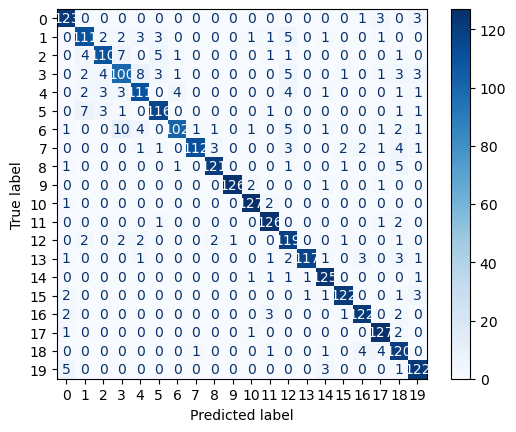

In [43]:
# Printing confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(0,20))
disp.plot(cmap="Blues")
plt.show()

## Making Predictions

In [44]:
# Making predictions with the test data
import pandas as pd
xTest_norm_p = sparse.hstack((np.ones((xTest_norm.shape[0], 1)), xTest_norm))
yPred = np.argmax(predict(W = WvChi, X = xTest_norm_p), axis=0) + 1

In [45]:
# Putting the predictions into a dataframe and exporting the results
predictions = pd.DataFrame(pd.DataFrame(yPred))
predictions.columns = ["class"]
predictions.index = np.arange(1, len(predictions) + 1)
predictions.set_index(pd.Index(range(12001, 12001 + len(predictions))), inplace=True)
predictions.index.name='id'
predictions.to_csv("predictions.csv")